<a href="https://colab.research.google.com/github/ChoiSenn/Study/blob/main/AI/SentimentAnalysis/Transformer%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer를 이용한 텍스트 분류



## 1. Sentencepiece를 활용해 Vocab 만들기

Google SentencePiece를 이용하여 Vocab을 만든다. 

- Character level : 한국어 기준으로 자음, 모음 단위로 vocab을 나누거나 글자 단위로 나누는 것. 모든 글자를 vocab으로 표현 가능하지만 각 단어의 고유한 의미를 표현하고 있는 것은 아니므로 좋은 성능을 내지 못하는 경우가 많다.

- space level : 띄어쓰기 단위로 만드는 방법. 한국어의 경우 조사/어미 등으로 인해 중복 단어 문제가 발생. 따라서 모든 단어를 다 vocab으로 만들 경우, vocab이 매우 커지게 되고 빈도수가 낮은 단어들은 잘 학습이 되지 않는다.

- subword level : 많은 단어를 처리하면서도 unknown이 발생할 확률을 줄이는 방법. 단어의 빈도수를 계산해서 subword 단위로 쪼갠다. google에서 sentencepiece라는 툴을 제공. 여기서는 subword 방법 중 BPE를 사용.

### 1-1. 말뭉치 만들기

Vocab을 만들기 위한 말뭉치가 필요. 이는 위키 백과의 한국어 위키 말뭉치를 사용한다. web-crawler를 이용해 텍스트 파일로 저장한다.

In [7]:
!git clone https://github.com/paul-hyun/web-crawler.git
!cd web-crawler
!pip install tqdm
!pip install pandas
!pip install bs4
!pip install wget
!pip install pymongo
!python kowiki.py

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
INFO: 122173	연천역
INFO: 122174	전곡역
INFO: 122176	허하백
INFO: 122178	.pm
INFO: 122179	한탄강역
INFO: 122180	초성리역
INFO: 122182	섀퍼
INFO: 122189	대한민국 제헌 헌법
INFO: 122190	남송 고종
INFO: 122191	NScripter
INFO: 122192	현대 그레이스
INFO: 122195	DRM
INFO: 122196	GARNET CROW
INFO: 122197	키리키리
INFO: 122203	파일 확장자
INFO: 122211	체계적 원소 이름
INFO: 122212	서일성
INFO: 122218	FIFA 여자 랭킹
INFO: 122250	해리 포터와 불의 잔
INFO: 122260	KFA
INFO: 122278	로스쿨의 영화들
INFO: 122301	채무조정 합의서
INFO: 122316	선례구속의 원칙
INFO: 122355	Ak 5
INFO: 122366	법무법인 태평양
INFO: 122367	법무법인 세종
INFO: 122369	유득공
INFO: 122370	박규수
INFO: 122371	정약용
INFO: 122372	발해
INFO: 122373	박지원 (1737년)
INFO: 122375	최창무
INFO: 122384	주메이라 에미리트 오피스 타워
INFO: 122397	법치주의
INFO: 122408	제2차 모리 개조내각
INFO: 122409	모리 내각
INFO: 122411	장익 (1933년)
INFO: 122412	키스 엘리슨
INFO: 122413	김정우 (축구인)
INFO: 122414	법철학
INFO: 122415	나웅
INFO: 122419	베네치아의 도제
INFO: 122421	2004년 AFC 아시안컵
INFO: 122422	안영일 (연극인)
INFO: 122423	유한요소법
INFO: 122425	사랑에 속고 돈에 울고
INFO: 122431	총몽 (만화)
INFO

In [8]:
import pandas as pd
import sys
import csv
 
csv.field_size_limit(sys.maxsize)

in_file = "/content/kowiki/kowiki_20221101.csv"
out_file = "kowiki.txt"
SEPARATOR = u"\u241D"
df = pd.read_csv(in_file, sep=SEPARATOR, engine="python")
with open(out_file, "w") as f:
  for index, row in df.iterrows():
    f.write(row["text"]) # title 과 text를 중복 되므로 text만 저장 함
    f.write("\n\n\n\n") # 구분자

내용이 중복되지 않도록 본문만 저장하고, 위키 문서별로 구분하기 위해 구분자로 줄바꿈을 4개 준다.

##1-2. Google SentencePiece 설치치

In [10]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.3 MB/s 


###1-3. Vocab 만들기

sentencepiece를 이용하여 Vocab을 생성.

In [11]:
import sentencepiece as spm

corpus = "kowiki.txt"
prefix = "kowiki"
vocab_size = 8000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

###1-4. Vocab 테스트

In [12]:
import sentencepiece as spm

vocab_file = "/content/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

lines = [
  "겨울이 되어서 날씨가 무척 추워요.",
  "이번 성탄절은 화이트 크리스마스가 될까요?",
  "겨울에 감기 조심하시고 행복한 연말 되세요."
]
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  print(line)
  print(pieces)
  print(ids)
  print()

겨울이 되어서 날씨가 무척 추워요.
['▁겨울', '이', '▁되어', '서', '▁날', '씨', '가', '▁무', '척', '▁추', '워', '요', '.']
[2404, 3898, 612, 3913, 617, 4356, 3908, 109, 4484, 189, 4274, 4065, 3902]

이번 성탄절은 화이트 크리스마스가 될까요?
['▁이', '번', '▁성', '탄', '절', '은', '▁화', '이트', '▁크리스', '마', '스가', '▁될', '까', '요', '?']
[7, 4130, 80, 4223, 4216, 3914, 267, 821, 2749, 3983, 785, 1332, 4103, 4065, 4651]

겨울에 감기 조심하시고 행복한 연말 되세요.
['▁겨울', '에', '▁감', '기', '▁조', '심', '하', '시', '고', '▁행', '복', '한', '▁연', '말', '▁되', '세', '요', '.']
[2404, 3900, 240, 3915, 53, 4124, 3904, 3921, 3909, 247, 4155, 3912, 63, 4128, 239, 3975, 4065, 3902]



subword 단위로 쪼개져서 출력되는 모습을 확인할 수 있다.

## 2. Naver 영화리뷰 감정분석 데이터 전처리

###2-1. 데이터 다운로드

In [13]:
! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2022-11-01 12:00:05--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.05s   

2022-11-01 12:00:06 (266 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2022-11-01 12:00:06--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving

###2-2. Vocab

1에서 만들어두었던 Vocab을 로드한다.

In [14]:
# vocab loading
vocab_file = "/content/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

2-3. 데이터 전처리

vocab을 미리 토크나이즈하여 json 형태로 저장해두어 시간을 절약한한다.

In [15]:
""" train data 준비 """
def prepare_train(vocab, infile, outfile):
    df = pd.read_csv(infile, sep="\t", engine="python")
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["document"]
            if type(document) != str:
                continue
            instance = { "id": row["id"], "doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

In [16]:
import json

prepare_train(vocab, "/content/ratings_train.txt", "/content/ratings_train.json")
prepare_train(vocab, "/content/ratings_test.txt", "/content/ratings_test.json")

## 3. Transformer 구현

###3-1. Vocab

1에서 만든 Vocab을 이용해 텍스트를 tensor로 변경.

In [17]:
import torch

# vocab loading
vocab_file = "/content/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[2404, 3914,  189, 4274, 4065, 3902,    0,    0],
        [ 240, 3915,   53, 4124, 3904, 3975, 4065, 3902]])


###3-2. Embedding

Transformer의 Embedding은 'Input Embedding'과 'Position Embedding' 두 가지를 함께 사용.

우선 Input Embedding은 입력 토큰을 vector 형태로 변환하는 것이다. input에 대한 embedding 값을 구하고 shpae를 출력.

In [18]:
from torch import nn

n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


position embedding은 우선 각 position별로 angle 값을 구하고, angle 값 중 짝수 index의 값에 대한 sin 값을 구하고, 홀수 index 값에 대한 cos 값을 구한다.

In [19]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(64, 128)


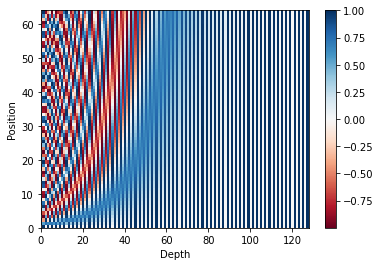

In [20]:
import numpy as np
import matplotlib.pyplot as plt

n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

position 별로 다른 값을 갖는 것을 확인할 수 있다.

위의 position encoding 값을 이용해 position embedding을 생성. 입력 input과 동일한 크기를 갖는 positions 값을 구하고 input 값 중 pad(0) 값을 찾고 embedding 값을 구한다.

In [21]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[2404, 3914,  189, 4274, 4065, 3902,    0,    0],
        [ 240, 3915,   53, 4124, 3904, 3975, 4065, 3902]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


구산 input_embs와 pos_embs를 더하면 Transformer에 입력할 input이 된다.

In [22]:
input_sums = input_embs + pos_embs

###3-3. Scaled Dot Product Attention

입력값은 Query, Key, Value, 그리고 attention mask로 구성되어 있다.

Q, K, V가 모두 동일한 경우를 self attention이라고 한다.

In [23]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


In [24]:
# Q * K - transpose
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

# k-dimension에 루트를 취한 값으로 나눔눔
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

# mask
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

# softmax
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

# attn_prov * V
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 8])
tensor([[193.3839,  48.8220,  71.8985,  51.5631,  60.3163,  21.0094,  92.8987,
          92.8987],
        [ 48.8220, 181.0234,  38.4523,  28.6754,  44.0072,  31.3441,  53.6017,
          53.6017],
        [ 71.8985,  38.4523, 212.6597,  61.4465,  72.6760,  39.5279,  64.1726,
          64.1726],
        [ 51.5631,  28.6754,  61.4465, 187.2013,  77.4778,  47.9019,  28.7648,
          28.7648],
        [ 60.3163,  44.0072,  72.6760,  77.4778, 207.1441,  61.7307,  32.4886,
          32.4886],
        [ 21.0094,  31.3441,  39.5279,  47.9019,  61.7307, 178.6674,  35.3170,
          35.3170],
        [ 92.8987,  53.6017,  64.1726,  28.7648,  32.4886,  35.3170, 179.0739,
         179.0739],
        [ 92.8987,  53.6017,  64.1726,  28.7648,  32.4886,  35.3170, 179.0739,
         179.0739]], grad_fn=<SelectBackward0>)
torch.Size([2, 8, 8])
tensor([[24.1730,  6.1027,  8.9873,  6.4454,  7.5395,  2.6262, 11.6123, 11.6123],
        [ 6.1027, 22.6279,  4.8065,  3.5844,  5.5009, 

In [25]:
# 위 절차를 한 클래스 형태로 압축
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

###3-4. Multi-Head Attention

Q, K, V, attn_mask는 위와 같으며, head 개수는 2개, head의 dimension은 64.

In [26]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

In [27]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


In [28]:
# Attention Mask도 multi-head로 변경

print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


In [29]:
# Attention 구하기
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


In [30]:
# Concat
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 8, 128])


In [31]:
# Linear 
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 8, 128])


In [32]:
# 위 내용을 하나의 클래스 형태로 정리

""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

###3-5. Masked Multi-Head Attention

attention mask 부분을 제외하면 Multi-Head Attention과 동일.

In [33]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


위에서 선언했던 MultiHeadAttention 클래스를 사용.

In [34]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


### 3-6. Feed-Forward

In [35]:
# Linear
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 8])


입력에 비해 hidden dimension이 네 배 커진 것을 확인.

In [36]:
# Activation
import torch.nn.functional as F

active = F.gelu
ff_2 = active(ff_1)

In [37]:
# f3 (Linear)
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


In [38]:
# 위의 내용을 한 클래스 형태로 구성.
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

###3-7. Config

여러 파라미터등의 설정을 json 형태로 저장하고 이를 읽어서 처리하는 클래스를 작성.

In [39]:
""" configuration json을 읽어들이는 class """
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

우선은 작은 리소스 환경에서도 동작 가능하도록 여러 파라미터를 작게 설정.

In [40]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


###3-8. Common Class

Position Embedding의 초깃값을 구하는 함수를 작성.

In [41]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

Attention을 구할 때 Padding 부분을 제외하기 위한 Mask를 구하는 함수 작성.

In [42]:
""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask= pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

Decoder의 Masked Multi Head Attention에서 사용할 Mask를 구하는 함수 작성. 현재 단어와 이전 단어는 볼 수 있고, 다음 단어는 볼 수 없도록 마스킹.

In [43]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

Scaled Dot Product Attention을 구하는 클래스를 작성.

In [44]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2))
        scores = scores.mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

Multi-Head Attention을 구하는 클래스.

In [45]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

Feed-Forward를 처리하는 클래스.

In [46]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.conv1(inputs.transpose(1, 2))
        output = self.active(output)
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

###3-9. Encoder

Encoder에서 루프를 돌며 처리할 수 있도록 EncoderLayer를 정의하고 여러 개 만들어서 실행.



In [47]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

Encoder 클래스 작성.

In [48]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

###3-10. Decoder

Decoder에서 루프를 돌며 처리할 수 있도록 DecoderLayer를 정의하고 여러 개 만들어서 실행.

In [49]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

Decoder 클래스 작성.

In [50]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

###3-11. Transformer

Transformer 클래스 작성.

Encoder Input을 입력으로 Encoder를 실행. Encoder Output과 Decoder Input을 입력으로 Decoder를 실행.

In [51]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs


###3-12. Model

Transformer 클래스를 이용하여 Naver 영화리뷰 감정분석 분류 모델 클래스를 정의.

Encoder input과 Decoder input을 입력으로 Transformer 모델을 실행. Transformer 출력의 max 값을 구하고 Linear를 실행하여 최종 예측 결과를 만든다.

In [52]:
""" naver movie classfication """
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        # (bs, n_output)
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs


###3-13. Dataset

입력 파일로부터 label을 읽어들이고, doc token을 읽어 숫자로 변경. Decoder 입력은 [BOS]로 고정.

In [53]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

배치 단위로 데이터 처리를 위한 collate_fn.

In [54]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

위에서 정의한 Dataset과 collate_fn을 이용해 학습용과 평가용 DataLoader를 작성.

In [55]:
from tqdm import tqdm

batch_size = 128
train_dataset = MovieDataSet(vocab, "/content/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, "/content/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading /content/ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 28791.39 lines/s]


###3-14. Evaluate

학습된 MovieClassitication 모델의 성능을 평가하기 위한 함수를 작성.

Encoder input과 Decoder input을 입력으로 MovieClassification을 실행. 첫 번째 값인 예측 logits의 최대값의 index를 구하여 labels의 값이 같은지 비교.

In [56]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

###3-15. Train

모델을 학습하기 위한 함수를 작성.

Encoder input과 Decoder input을 입력으로 MovieClassification을 실행. 결과 중 첫 번째 값인 예측 logits의 값과 labels의 값을 이용해 Loss를 계산. loss와 optimizer를 이용해 학습.

In [57]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

학습을 위해 GPU 사용 여부, 출력 값의 개수(부정/긍정 두 가지), learning_rate와 학습 epoch을 선언.

In [58]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


선언된 내용을 이용해 학습을 실행.

MovieClassification을 생성하고 GPU를 지원하도록 설정. loss 함수와 optimizer를 선언. 각 epoch마다 학습, 평가.

In [59]:
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

Valid: 100%|██████████| 391/391 [00:52<00:00,  7.47it/s, Acc: 0.834]


###3-16. Result

학습 및 평가 결과를 출력.

정확도는 약 83.5%.

,loss,score
0,0.486559,0.802728
1,0.403768,0.805088
2,0.375602,0.825210
3,0.354846,0.829190
4,0.335384,0.830090
5,0.313667,0.833350
6,0.292575,0.833270
7,0.271614,0.833490
8,0.248205,0.834590
9,0.227539,0.834310


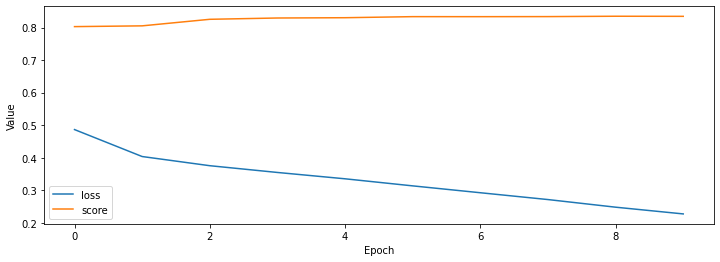

In [60]:
# table
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

코드 출처 : https://paul-hyun.github.io/